In [1]:
import sys, os, glob
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import tensorflow as tf
# from libs.activations import lrelu
import math
import numpy as np
import random as rnd

In [2]:
# %%
# load training image
train_images = np.load('train_images.npy')
print(train_images.shape)
# mean_img = np.mean(train_images, axis=0)
# print('mean_img.shape =', mean_img.shape)
# plt.figure()
# plt.imshow(mean_img[:, :, 0], cmap='gray')

# load training cmd
train_cmds = np.load("train_cmds.npy")
print(train_cmds.shape)
train_steps = train_cmds[:, 0]
train_angles = train_cmds[:, 1]
print(train_steps.shape, train_angles.shape)

# load training image2
train_images2 = np.load('train_images2.npy')
print(train_images2.shape)
# mean_img2 = np.mean(train_images2, axis=0)
# print('mean_img2.shape =', mean_img2.shape)
# plt.figure()
# plt.imshow(mean_img2[:, :, 0], cmap='gray')

# load training cmd2
train_cmds2 = np.load("train_cmds2.npy")
print(train_cmds2.shape)
train_steps2 = train_cmds2[:, 0]
train_angles2 = train_cmds2[:, 1]
print(train_steps2.shape, train_angles2.shape)

(40000, 40, 320, 1)
(39999, 3)
(39999,) (39999,)
(40000, 40, 320, 1)
(39999, 3)
(39999,) (39999,)


In [3]:
def add_encoder_layer(x, n_filters, filter_size, strides, deta=200.0):
    # %%
    # input to the network
#     x = tf.placeholder(tf.float32, input_shape, name='x')

    # %%
    # ensure input is 4-d.
    if len(x.get_shape()) != 4:
        raise ValueError('Unsupported input dimensions')
    input_shape = x.get_shape()
    print('The input layer x has shape', input_shape)
    
    # %%
    # Build the encoder
    n_input = x.get_shape().as_list()[3]
    n_output = n_filters
    W = tf.Variable(
            tf.random_uniform([filter_size[0], filter_size[1], n_input, n_output],
                -1.0 / math.sqrt(filter_size[0]*filter_size[1]*n_input),
                1.0 / math.sqrt(filter_size[0]*filter_size[1]*n_input)))
    b = tf.Variable(tf.zeros([n_output]))
    z = tf.nn.relu(tf.add(tf.nn.conv2d(x, W, strides=[1, strides[0], strides[1], 1], padding='VALID'), b))
    print('The encoding layer z has shape', z.get_shape())

    # %%
    # Build the decoder using the same weights
    b2 = tf.Variable(tf.zeros([n_input]))
    y = tf.nn.relu(tf.add(tf.nn.conv2d_transpose(z, W, input_shape, strides=[1, strides[0], strides[1], 1], padding='VALID'), b2))
    print('The output layer y has shape', y.get_shape())

    # %%
    # the reconstruction through the network
    # cost function measures pixel-wise difference
    cost = tf.reduce_sum(tf.square(y - x))
        
    l2_regularizer = tf.contrib.layers.l2_regularizer(scale=deta, scope=None)
#   weights = tf.trainable_variables()
    l2_cost = tf.contrib.layers.apply_regularization(l2_regularizer, [W])
        
    cost_t = cost + l2_cost

    # %%
    # define the optimizer
    learning_rate = 0.001
    optimizer = tf.train.AdamOptimizer(learning_rate).minimize(cost_t)
        
    # %%
    # dict for inputs, outputs, and costs
    ae = {'z': z, 'y': y, 'W': W, 'b': b, 'b2': b2, 'cost': cost, 'l2_cost': l2_cost, 'cost_t': cost_t, 'optimizer':optimizer}
        
    return ae

In [13]:
saved_model = 'modelxxx3'
example_num = 40

# %%
# Fit training data
tf.reset_default_graph()
g = tf.Graph()
with g.as_default():
    input_shape = [example_num, 40, 320, 1]
    n_filters = 10
    filter_size = [8, 10]
    strides = [4, 5]
    x = tf.placeholder(tf.float32, input_shape, name='x')
    ae = add_encoder_layer(x, n_filters, filter_size, strides)
    
    sess = tf.Session()
    # initialize the weights or load the trained weights
#     sess.run(tf.global_variables_initializer())
    
    # reload the pretrained model
    restorer = tf.train.Saver()
    restorer.restore(sess, 'model/' + saved_model)

    n_epochs = 2
    for epoch_i in range(n_epochs):
        for batch_i in range(train_images.shape[0]-example_num):
            batch_xs = train_images[batch_i:(batch_i+example_num), :, :, :]
#             train = np.array([img - mean_img for img in batch_xs])
            train = batch_xs
            sess.run(ae['optimizer'], feed_dict={x: train})
            if batch_i % 1000 == 0:
                cost, l2_cost, cost_t = sess.run([ae['cost'], ae['l2_cost'], ae['cost_t']], feed_dict={x: train})
                print(epoch_i, ':1:', batch_i, ':cost =', cost, 'l2_cost =', l2_cost,  'cost_t =', cost_t)
        for batch_i in range(train_images.shape[0]-example_num):
            batch_xs = train_images2[batch_i:(batch_i+example_num), :, :, :]
#             train = np.array([img - mean_img2 for img in batch_xs])
            train = batch_xs
            sess.run(ae['optimizer'], feed_dict={x: train})
            if batch_i % 1000 == 0:
                cost, l2_cost, cost_t = sess.run([ae['cost'], ae['l2_cost'], ae['cost_t']], feed_dict={x: train})
                print(epoch_i, ':2:', batch_i, ':cost =', cost, 'l2_cost =', l2_cost,  'cost_t =', cost_t)

    saver = tf.train.Saver()
    save_path = saver.save(sess, 'model/' + saved_model)
    print("Model saved in file: %s" % save_path)

The input layer x has shape (40, 40, 320, 1)
The encoding layer z has shape (40, 9, 63, 10)
The output layer y has shape (40, 40, 320, 1)
INFO:tensorflow:Restoring parameters from model/modelxxx3
0 :1: 0 :cost = 1604.2 l2_cost = 543.995 cost_t = 2148.19
0 :1: 1000 :cost = 1266.58 l2_cost = 512.459 cost_t = 1779.04
0 :1: 2000 :cost = 1689.22 l2_cost = 528.638 cost_t = 2217.86
0 :1: 3000 :cost = 1345.42 l2_cost = 562.952 cost_t = 1908.37
0 :1: 4000 :cost = 1497.98 l2_cost = 547.136 cost_t = 2045.12
0 :1: 5000 :cost = 1523.24 l2_cost = 556.357 cost_t = 2079.6
0 :1: 6000 :cost = 1356.1 l2_cost = 535.516 cost_t = 1891.62
0 :1: 7000 :cost = 1268.84 l2_cost = 519.46 cost_t = 1788.3
0 :1: 8000 :cost = 1712.15 l2_cost = 577.839 cost_t = 2289.99
0 :1: 9000 :cost = 1544.44 l2_cost = 557.751 cost_t = 2102.19
0 :1: 10000 :cost = 1324.17 l2_cost = 535.671 cost_t = 1859.84
0 :1: 11000 :cost = 1521.35 l2_cost = 565.329 cost_t = 2086.68
0 :1: 12000 :cost = 1203.15 l2_cost = 525.887 cost_t = 1729.04
0 :

1 :2: 9000 :cost = 1246.97 l2_cost = 578.067 cost_t = 1825.03
1 :2: 10000 :cost = 1454.14 l2_cost = 573.017 cost_t = 2027.16
1 :2: 11000 :cost = 1310.58 l2_cost = 540.943 cost_t = 1851.52
1 :2: 12000 :cost = 1275.16 l2_cost = 527.085 cost_t = 1802.25
1 :2: 13000 :cost = 1307.02 l2_cost = 563.415 cost_t = 1870.43
1 :2: 14000 :cost = 1200.08 l2_cost = 569.253 cost_t = 1769.33
1 :2: 15000 :cost = 1146.3 l2_cost = 513.262 cost_t = 1659.56
1 :2: 16000 :cost = 1394.12 l2_cost = 545.652 cost_t = 1939.77
1 :2: 17000 :cost = 1413.83 l2_cost = 534.811 cost_t = 1948.64
1 :2: 18000 :cost = 1459.04 l2_cost = 557.097 cost_t = 2016.14
1 :2: 19000 :cost = 1350.51 l2_cost = 552.093 cost_t = 1902.6
1 :2: 20000 :cost = 1395.0 l2_cost = 571.236 cost_t = 1966.24
1 :2: 21000 :cost = 1182.97 l2_cost = 578.262 cost_t = 1761.23
1 :2: 22000 :cost = 1233.24 l2_cost = 558.655 cost_t = 1791.9
1 :2: 23000 :cost = 1298.13 l2_cost = 526.692 cost_t = 1824.82
1 :2: 24000 :cost = 1502.13 l2_cost = 589.729 cost_t = 2091.

The input layer x has shape (4, 40, 320, 1)
The encoding layer z has shape (4, 9, 63, 10)
The output layer y has shape (4, 40, 320, 1)
INFO:tensorflow:Restoring parameters from model/modelxxx3
[ 0.  0.  0.] [-10. -10. -10.]
[ 0.  0.  2.] [-10. -10.   0.]
(8, 40, 320, 1) (8, 40, 320, 1)


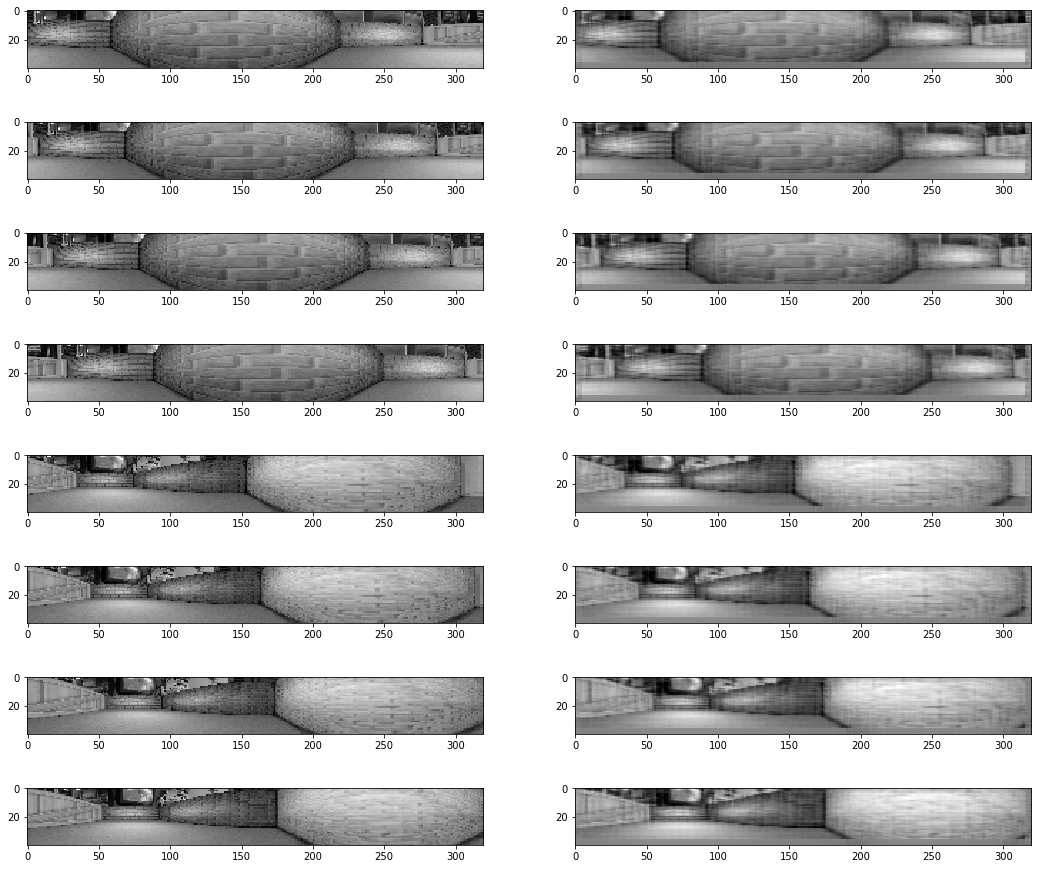

In [14]:
saved_model = 'modelxxx3'
example_num = 4

# %%
# Plot reconstruction example
tf.reset_default_graph()
g = tf.Graph()
with g.as_default():
    input_shape = [example_num, 40, 320, 1]
    n_filters = 10
    filter_size = [8, 10]
    strides = [4, 5]
    x = tf.placeholder(tf.float32, input_shape, name='x')
    ae = add_encoder_layer(x, n_filters, filter_size, strides)
    
    sess = tf.Session()
    # reload the pretrained model
    restorer = tf.train.Saver()
    restorer.restore(sess, 'model/' + saved_model)

    start = int(rnd.random()*(40000-example_num-1))
    test_xs = train_images[start:(start+example_num), :, :, :]
#     test_xs_norm = np.array([img - mean_img for img in test_xs])
    test_xs_norm = test_xs
    steps_test = train_steps[start:(start+example_num-1)]
    angles_test = train_angles[start:(start+example_num-1)]
    print(steps_test, angles_test)
    recon = sess.run(ae['y'], feed_dict={x: test_xs_norm})

    test_xs2 = train_images2[start:(start+example_num), :, :, :]
#     test_xs_norm = np.array([img - mean_img2 for img in test_xs2])
    test_xs_norm = test_xs2
    steps_test = train_steps2[start:(start+example_num-1)]
    angles_test = train_angles2[start:(start+example_num-1)]
    print(steps_test, angles_test)
    recon2 = sess.run(ae['y'], feed_dict={x: test_xs_norm})

    test_xs = np.concatenate((test_xs, test_xs2), axis=0)
    recon = np.concatenate((recon, recon2), axis=0)
    print(test_xs.shape, recon.shape)
    fig, axs = plt.subplots(example_num*2, 2, figsize=(18, 4*example_num))
    for example_i in range(example_num*2):
        axs[example_i][0].imshow(test_xs[example_i, :, :, 0], cmap='gray')
        if example_i < example_num/2:
#             axs[example_i][1].imshow(recon[example_i, :, :, 0] + mean_img[:, :, 0], cmap='gray')
            axs[example_i][1].imshow(recon[example_i, :, :, 0], cmap='gray')
        else:
#             axs[example_i][1].imshow(recon[example_i, :, :, 0] + mean_img2[:, :, 0], cmap='gray')
            axs[example_i][1].imshow(recon[example_i, :, :, 0], cmap='gray')
    plt.show()

The input layer x has shape (40, 40, 320, 1)
The encoding layer z has shape (40, 9, 63, 10)
The output layer y has shape (40, 40, 320, 1)
INFO:tensorflow:Restoring parameters from model/modelxxx3
step commands are [ 0.  0.  0.  0.  2.  0.  0.  0.  0.  0.  2.  2.  2.  0.  0.  0.  0.  2.
  2.  2.  2.  2.  0.  0.  0.  0.  0.  2.  2.  2.  0.  0.  0.  2.  0.  2.
  0.  0.  0.]
angle commands are [ 10.  10.  10.  10.   0.  10.  10.  10.  10.  10.   0.   0.   0. -10. -10.
 -10. -10.   0.   0.   0.   0.   0.  10.  10.  10.  10.  10.   0.   0.   0.
  10.  10.  10.   0.  10.   0.  10.  10.  10.]
step commands are [ 0.  0.  0.  0.  0.  0.  0.  0.  2.  0.  0.  2.  2.  2.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  2.  2.  2.  0.
  0.  0.  0.]
angle commands are [-10. -10. -10. -10. -10. -10. -10. -10.   0. -10. -10.   0.   0.   0.  10.
  10.  10.  10.  10.  10.  10.  10.  10.  10.  10.  10.  10.  10.  10.  10.
  10.  10.   0.   0.   0. -10. -10. -10. -10.]
z1.shape = (

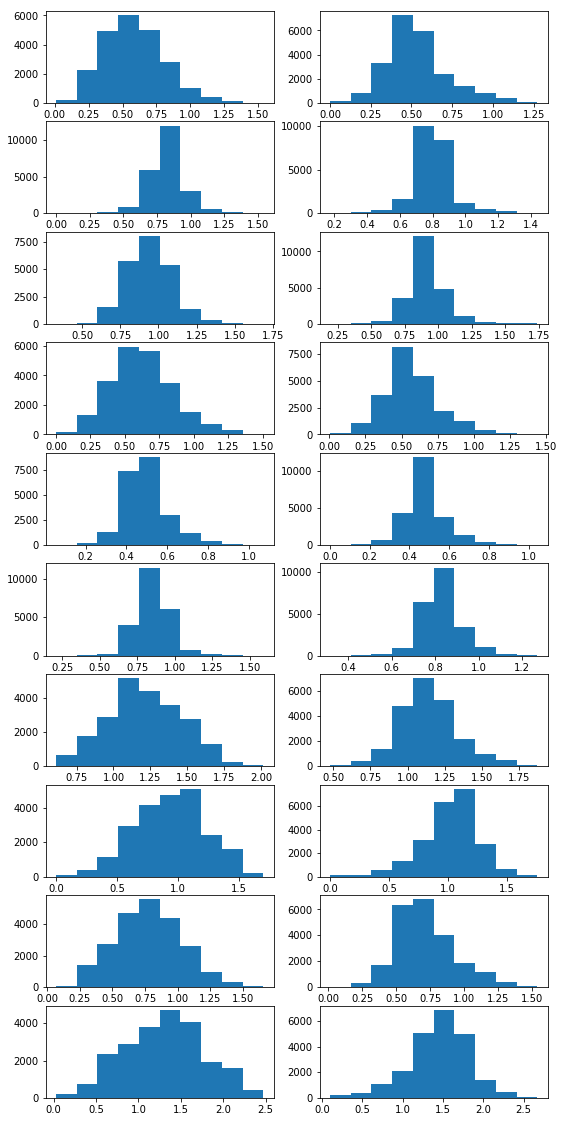

In [15]:
# %%
# Plot activation of neurons
saved_model = 'modelxxx3'
example_num = 40

# %%
# Plot reconstruction example
tf.reset_default_graph()
g = tf.Graph()
with g.as_default():
    input_shape = [example_num, 40, 320, 1]
    n_filters = 10
    filter_size = [8, 10]
    strides = [4, 5]
    x = tf.placeholder(tf.float32, input_shape, name='x')
    ae = add_encoder_layer(x, n_filters, filter_size, strides)
    
    sess = tf.Session()
    restorer = tf.train.Saver()
    restorer.restore(sess, 'model/' + saved_model)
    
    start = int(rnd.random()*(40000-example_num-1))
    test_xs = train_images[start:(start+example_num), :, :, :]
    test_xs_norm = test_xs
    steps_test = train_steps[start:(start+example_num-1)]
    angles_test = train_angles[start:(start+example_num-1)]
    print('step commands are', steps_test)
    print('angle commands are', angles_test)
    z1 = sess.run(ae['z'], feed_dict={x: test_xs_norm})

    test_xs2 = train_images2[start:(start+example_num), :, :, :]
    test_xs_norm = test_xs2
    steps_test = train_steps2[start:(start+example_num-1)]
    angles_test = train_angles2[start:(start+example_num-1)]
    print('step commands are', steps_test)
    print('angle commands are', angles_test)
    z2 = sess.run(ae['z'], feed_dict={x: test_xs_norm})

    print('z1.shape =', z1.shape)
    print('z2.shape =', z2.shape)

shape = z1.shape.as_list()
tmp1 = np.reshape(z1, (shape[0]*shape[1]*shape[2], shape[3]))
# plt.hist(tmp1[:, 0])
tmp2 = np.reshape(z2, (shape[0]*shape[1]*shape[2], shape[3]))
fig, axes = plt.subplots(10, 2, figsize=(9, 20))
for idx in range(10):
    axes[idx, 0].hist(tmp1[:, idx])
    axes[idx, 1].hist(tmp2[:, idx])

### Get the pretained weights

The input layer x has shape (2, 40, 320, 1)
The encoding layer z has shape (2, 9, 63, 10)
The output layer y has shape (2, 40, 320, 1)
INFO:tensorflow:Restoring parameters from model/modelxxx3
w1.shape =  (8, 10, 1, 10) b1.shape =  (10,)
w1_val.shape = (8, 10, 1, 10)
max 0.188276 min -0.258297
max 0.195832 min -0.284833
max 0.269719 min -0.266409
max 0.165591 min -0.321095
max 0.17104 min -0.34666
max 0.295261 min -0.16514
max 0.186171 min -0.201123
max 0.25863 min -0.185888
max 0.18916 min -0.279841
max 0.261533 min -0.0690637


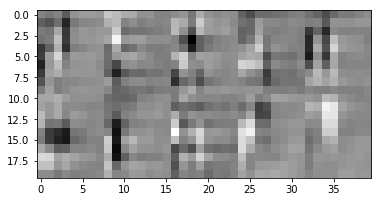

In [16]:
# %%
# Plot activation of neurons
saved_model = 'modelxxx3'
example_num = 2

# %%
# Plot reconstruction example
tf.reset_default_graph()
g = tf.Graph()
with g.as_default():
    input_shape = [example_num, 40, 320, 1]
    n_filters = 10
    filter_size = [8, 10]
    strides = [4, 5]
    x = tf.placeholder(tf.float32, input_shape, name='x')
    ae = add_encoder_layer(x, n_filters, filter_size, strides)
    
    sess = tf.Session()
    restorer = tf.train.Saver()
    restorer.restore(sess, 'model/' + saved_model)
    
    w1, b1 = sess.run([ae['W'], ae['b']])
    print('w1.shape = ', w1.shape, 'b1.shape = ', b1.shape)
    np.save('model/w1.npy', w1)
    np.save('model/b1.npy', b1)
    
w1_val = np.load('model/w1.npy')
print('w1_val.shape =', w1_val.shape)
h = w1_val.shape[0]
w = w1_val.shape[1]
wi_image = np.zeros([h*5, w*2])
for i in range(5):
    for j in range(2):
        wi_image[i*h:(i+1)*h, j*w:(j+1)*w] = w1_val[:, :, 0, 2*i+j]
        print('max', np.max(w1_val[:, :, 0, 2*i+j]), 'min', np.min(w1_val[:, :, 0, 2*i+j]))
plt.imshow(np.transpose(wi_image), cmap='gray')

### Build the Predict Layer

In [5]:
def add_encoder_layer_with_weight(x, weight_file, bias_file, strides):
    
    # %%
    # ensure input is 4-d.
    if len(x.get_shape()) != 4:
        raise ValueError('Unsupported input dimensions')
    input_shape = x.get_shape()
    print('The input layer x has shape', input_shape)
    
    # %%
    # Build the encoder
    W_val = np.load('model/' + weight_file)
    W = tf.constant(W_val)
    b_val = np.load('model/' + bias_file)
    b = tf.constant(b_val)
    z = tf.nn.relu(tf.add(tf.nn.conv2d(x, W, strides=[1, strides[0], strides[1], 1], padding='VALID'), b))
    print('The encoding layer z has shape', z.get_shape())
        
    # %%
    # dict for inputs, outputs, and costs
    ae = {'z': z}
        
    return ae

def add_predict_layer(encode_layer_t1, encode_layer_t2, filter_size, strides, head_cell_n, place_cell_n):
    
    print('encode_layer_t1 has shape =', encode_layer_t1.get_shape())
    print('encode_layer_t2 has shape =', encode_layer_t2.get_shape())
    shape = encode_layer_t1.get_shape()
    n_input = shape.as_list()[3]
#     print(n_input)
    
    # %%
    # Build head cells
    n_output = head_cell_n
    w2 = tf.Variable(tf.random_uniform([filter_size[0], filter_size[1], n_input, n_output],
                                       -1.0/math.sqrt(n_input), 1.0/math.sqrt(n_input)))
    b2 = tf.Variable(tf.zeros([n_output]))
    head_layer_t1 = tf.nn.relu(tf.add(
        tf.nn.conv2d(encode_layer_t1, w2, strides=[1, strides[0], strides[1], 1], padding='VALID'), b2))
    print('head_layer_t1 has shape =', head_layer_t1.get_shape())
    
    # %%
    # predict encode_layer_t2 using head_layer_t1
    b2_2 = tf.Variable(tf.zeros([n_input]))
    encode_layer_t2_H = tf.nn.relu(tf.add(
        tf.nn.conv2d_transpose(head_layer_t1, w2, shape, strides=[1, strides[0], strides[1], 1], padding='VALID'), b2_2))
    print('encode_layer_t2_H has shape =', encode_layer_t2_H.get_shape())
    # %%
    # cost function measures pixel-wise difference
    cost1 = tf.reduce_sum(tf.square(encode_layer_t2_H - encode_layer_t2))
    
    # %%
    # Build place cells
    n_output = place_cell_n
    w3 = tf.Variable(tf.random_uniform([filter_size[0], filter_size[1], n_input, n_output],
                                       -1.0/math.sqrt(n_input), 1.0/math.sqrt(n_input)))
    b3 = tf.Variable(tf.zeros([n_output]))
    place_layer_t1 = tf.nn.relu(tf.add(
        tf.nn.conv2d(encode_layer_t1, w3, strides=[1, strides[0], strides[1], 1], padding='VALID'), b3))
    print('place_layer_t1 has shape =', place_layer_t1.get_shape())
    
    # %%
    # predict Code_layer_1_t2 using head_layer_1_t1
    b3_2 = tf.Variable(tf.zeros([n_input]))
    encode_layer_t2_P = tf.nn.relu(tf.add(
        tf.nn.conv2d_transpose(place_layer_t1, w3, shape, strides=[1, strides[0], strides[1], 1], padding='VALID'), b3_2))
    print('encode_layer_t2_P has shape =', encode_layer_t2_P.get_shape())
    # %%
    # cost function measures pixel-wise difference
    cost2 = tf.reduce_sum(tf.square(encode_layer_t2_P - encode_layer_t2))

    # %%
    # define the optimizer
    learning_rate = 0.001
    optimizer1 = tf.train.AdamOptimizer(learning_rate).minimize(cost1, var_list=[w2, b2, b2_2])
    optimizer2 = tf.train.AdamOptimizer(learning_rate).minimize(cost2, var_list=[w3, b3, b3_2])
        
    # %%
    # dict for inputs, outputs, and costs
    pred = {'w2': w2, 'b2': b2, 'w3': w3, 'b3': b3, 'cost1': cost1, 'cost2': cost2, \
            'head_layer_t1': head_layer_t1, 'place_layer_t1': place_layer_t1, 'optimizer1': optimizer1, 'optimizer2': optimizer2}
        
    return pred

def add_predict_layer2(encode_layer_t1, encode_layer_t2, filter_size, strides, cell_n):
    
    print('encode_layer_t1 has shape =', encode_layer_t1.get_shape())
    print('encode_layer_t2 has shape =', encode_layer_t2.get_shape())
    shape = encode_layer_t1.get_shape()
    n_input = shape.as_list()[3]
#     print(n_input)
    
    # %%
    # Build predict cells
    n_output = cell_n
    w2 = tf.Variable(tf.random_uniform([filter_size[0], filter_size[1], n_input, n_output],
                                       -1.0/math.sqrt(n_input), 1.0/math.sqrt(n_input)))
    b2 = tf.Variable(tf.zeros([n_output]))
    pred_layer_t1 = tf.nn.relu(tf.add(
        tf.nn.conv2d(encode_layer_t1, w2, strides=[1, strides[0], strides[1], 1], padding='VALID'), b2))
    print('pred_layer_t1 has shape =', pred_layer_t1.get_shape())
    
    # %%
    # predict encode_layer_t2 using pred_layer_t1
    b2_2 = tf.Variable(tf.zeros([n_input]))
    encode_layer_t2_pred = tf.nn.relu(tf.add(
        tf.nn.conv2d_transpose(pred_layer_t1, w2, shape, strides=[1, strides[0], strides[1], 1], padding='VALID'), b2_2))
    print('encode_layer_t2_pred has shape =', encode_layer_t2_pred.get_shape())
    # %%
    # cost function measures pixel-wise difference
    cost = tf.reduce_sum(tf.square(encode_layer_t2_pred - encode_layer_t2))

    # %%
    # define the optimizer
    learning_rate = 0.001
    optimizer = tf.train.AdamOptimizer(learning_rate).minimize(cost, var_list=[w2, b2, b2_2])
        
    # %%
    # dict for inputs, outputs, and costs
    pred = {'w2': w2, 'b2': b2, 'cost': cost, 'pred_layer_t1': pred_layer_t1, 'optimizer': optimizer}
        
    return pred

def add_predict_layer_with_weight(x, H_weight_file, H_bias_file, P_weight_file, P_bias_file, strides):
    
    # %%
    # ensure input is 4-d.
    if len(x.get_shape()) != 4:
        raise ValueError('Unsupported input dimensions')
    input_shape = x.get_shape()
    print('The input layer x has shape', input_shape)
    
    # %%
    # Build the head layer
    H_W_val = np.load('model/' + H_weight_file)
    H_W = tf.constant(H_W_val)
    H_b_val = np.load('model/' + H_bias_file)
    H_b = tf.constant(H_b_val)
    head_layer = tf.nn.relu(tf.add(tf.nn.conv2d(x, H_W, strides=[1, strides[0], strides[1], 1], padding='VALID'), H_b))
    print('The head_layer has shape', head_layer.get_shape())
    
    # %%
    # Build the place layer
    P_W_val = np.load('model/' + P_weight_file)
    P_W = tf.constant(P_W_val)
    P_b_val = np.load('model/' + P_bias_file)
    P_b = tf.constant(P_b_val)
    place_layer = tf.nn.relu(tf.add(tf.nn.conv2d(x, P_W, strides=[1, strides[0], strides[1], 1], padding='VALID'), P_b))
    print('The place_layer has shape', place_layer.get_shape())
        
    z = tf.concat([head_layer, place_layer], 3)
    print('The layer z has shape', z.get_shape())
    
    # %%
    # dict for inputs, outputs, and costs
    ae = {'z': z, 'z1': head_layer, 'z2': place_layer}
        
    return ae

def add_predict_layer_with_weight2(x, weight_file, bias_file, strides):
    
    # %%
    # ensure input is 4-d.
    if len(x.get_shape()) != 4:
        raise ValueError('Unsupported input dimensions')
    input_shape = x.get_shape()
    print('The input layer x has shape', input_shape)
    
    # %%
    # Add the predict layer
    W_val = np.load('model/' + weight_file)
    W = tf.constant(W_val)
    b_val = np.load('model/' + bias_file)
    b = tf.constant(b_val)
    pred_layer = tf.nn.relu(tf.add(tf.nn.conv2d(x, W, strides=[1, strides[0], strides[1], 1], padding='VALID'), b))
    print('The pred_layer has shape', pred_layer.get_shape())
    
    # %%
    # dict for inputs, outputs, and costs
    ae = {'z': pred_layer}
        
    return ae

In [6]:
saved_model = 'modelxxx4'
example_num = 1

# %%
# Fit training data
tf.reset_default_graph()
g = tf.Graph()
with g.as_default():
    input_shape = [example_num, 40, 320, 1]
    weight_file = 'w1.npy'
    bias_file = 'b1.npy'
    strides = [4, 5]
    x1 = tf.placeholder(tf.float32, input_shape, name='x1')
    x2 = tf.placeholder(tf.float32, input_shape, name='x2')
    ae1 = add_encoder_layer_with_weight(x1, weight_file, bias_file, strides)
    ae2 = add_encoder_layer_with_weight(x2, weight_file, bias_file, strides)
    
    filter_size = [3, 3]
    strides = [3, 3]
    head_cell_n = 40
    place_cell_n = 30
    pred = add_predict_layer(ae1['z'], ae2['z'], filter_size, strides, head_cell_n, place_cell_n)
    
    sess = tf.Session()
    
    # initialize the weights or load the trained weights
#     sess.run(tf.global_variables_initializer())
    
    restorer = tf.train.Saver()
    restorer.restore(sess, 'model/' + saved_model)

    n_epochs = 10
    for epoch_i in range(n_epochs):
        for batch_i in range(train_images.shape[0]-1):
            train1 = train_images[batch_i:(batch_i+example_num), :, :, :]
            train2 = train_images[batch_i+1:(batch_i+1+example_num), :, :, :]
            train_step = train_steps[batch_i]
            train_angle = train_angles[batch_i]
            if train_step != 0:
                sess.run(pred['optimizer1'], feed_dict={x1: train1, x2: train2})
            if train_angle != 0:
                sess.run(pred['optimizer2'], feed_dict={x1: train1, x2: train2})
            if batch_i % 10000 == 0:
                cost1_val, cost2_val = sess.run([pred['cost1'], pred['cost2']], feed_dict={x1: train1, x2: train2})
                print(epoch_i, ':', batch_i, 'step = ', train_step, 'angle =', train_angle, ':1:cost1 =', cost1_val, "cost2 =", cost2_val)
        for batch_i in range(train_images.shape[0]-1):
            train1 = train_images2[batch_i:(batch_i+example_num), :, :, :]
            train2 = train_images2[batch_i+1:(batch_i+1+example_num), :, :, :]
            train_step = train_steps2[batch_i]
            train_angle = train_angles2[batch_i]
            if train_step != 0:
                sess.run(pred['optimizer1'], feed_dict={x1: train1, x2: train2})
            if train_angle != 0:
                sess.run(pred['optimizer2'], feed_dict={x1: train1, x2: train2})
            if batch_i % 10000 == 0:
                cost1_val, cost2_val = sess.run([pred['cost1'], pred['cost2']], feed_dict={x1: train1, x2: train2})
                print(epoch_i, ':', batch_i, 'step = ', train_step, 'angle =', train_angle, ':1:cost1 =', cost1_val, "cost2 =", cost2_val)

    w2, b2, w3, b3 = sess.run([pred['w2'], pred['b2'], pred['w3'], pred['b3']])
    print('w2.shape = ', w2.shape, 'b2.shape = ', b2.shape, 'w3.shape = ', w3.shape, 'b3.shape = ', b3.shape)
    np.save('model/w2.npy', w2)
    np.save('model/b2.npy', b2)
    np.save('model/w3.npy', w3)
    np.save('model/b3.npy', b3)
    
    saver = tf.train.Saver()
    save_path = saver.save(sess, 'model/' + saved_model)
    print("Model saved in file: %s" % save_path)

The input layer x has shape (1, 40, 320, 1)
The encoding layer z has shape (1, 9, 63, 10)
The input layer x has shape (1, 40, 320, 1)
The encoding layer z has shape (1, 9, 63, 10)
encode_layer_t1 has shape = (1, 9, 63, 10)
encode_layer_t2 has shape = (1, 9, 63, 10)
head_layer_t1 has shape = (1, 3, 21, 40)
encode_layer_t2_H has shape = (1, 9, 63, 10)
place_layer_t1 has shape = (1, 3, 21, 30)
encode_layer_t2_P has shape = (1, 9, 63, 10)
INFO:tensorflow:Restoring parameters from model/modelxxx4
0 : 0 step =  1.99999999998 angle = 0.0 :1:cost1 = 39.5878 cost2 = 55.4707
0 : 10000 step =  0.0 angle = -10.0 :1:cost1 = 99.5539 cost2 = 78.7312
0 : 20000 step =  0.0 angle = 9.99999999998 :1:cost1 = 174.548 cost2 = 145.026
0 : 30000 step =  0.0 angle = -10.0 :1:cost1 = 149.607 cost2 = 122.21
0 : 0 step =  0.0 angle = 9.99999999998 :1:cost1 = 171.188 cost2 = 142.525
0 : 10000 step =  0.0 angle = 10.0 :1:cost1 = 175.501 cost2 = 139.269
0 : 20000 step =  0.0 angle = -9.99999999997 :1:cost1 = 124.406

In [8]:
saved_model = 'modelxxx5'
example_num = 40

# %%
# Fit training data
tf.reset_default_graph()
g = tf.Graph()
with g.as_default():
    input_shape = [example_num, 40, 320, 1]
    weight_file = 'w1.npy'
    bias_file = 'b1.npy'
    strides = [4, 5]
    x = tf.placeholder(tf.float32, input_shape, name='x')
    ae1 = add_encoder_layer_with_weight(x, weight_file, bias_file, strides)
    
    strides = [3, 3]
    H_weight_file = 'w2.npy'
    H_bias_file = 'b2.npy'
    pred1_H = add_predict_layer_with_weight2(ae1['z'], H_weight_file, H_bias_file, strides)
    P_weight_file = 'w3.npy'
    P_bias_file = 'b3.npy'
    pred1_P = add_predict_layer_with_weight2(ae1['z'], P_weight_file, P_bias_file, strides)
    
    n_filters = 40
    filter_size = [3, 3]
    strides = [1, 1]
    ae2_H = add_encoder_layer(pred1_H['z'], n_filters, filter_size, strides, 10.0)
    n_filters = 30
    ae2_P = add_encoder_layer(pred1_P['z'], n_filters, filter_size, strides, 10.0)
    
    sess = tf.Session()
    # initialize the weights or load the trained weights
    sess.run(tf.global_variables_initializer())
    
    # reload the pretrained model
#     restorer = tf.train.Saver()
#     restorer.restore(sess, 'model/' + saved_model)

    n_epochs = 3
    for epoch_i in range(n_epochs):
        for batch_i in range(train_images.shape[0]-example_num):
            batch_xs = train_images[batch_i:(batch_i+example_num), :, :, :]
#             train = np.array([img - mean_img for img in batch_xs])
            train = batch_xs
            sess.run([ae2_H['optimizer'], ae2_P['optimizer']], feed_dict={x: train})
            if batch_i % 1000 == 0:
                cost_H, l2_cost_H, cost_t_H, cost_P, l2_cost_P, cost_t_P = sess.run([ae2_H['cost'], ae2_H['l2_cost'], ae2_H['cost_t'],
                                                  ae2_P['cost'], ae2_P['l2_cost'], ae2_P['cost_t']], feed_dict={x: train})
                print(epoch_i, ':1:', batch_i, ':cost_H =', cost_H, 'l2_cost_H =', l2_cost_H,  'cost_t_H =', cost_t_H, 
                     ':cost_P =', cost_P, 'l2_cost_P =', l2_cost_P,  'cost_t_P =', cost_t_P)
        for batch_i in range(train_images.shape[0]-example_num):
            batch_xs = train_images2[batch_i:(batch_i+example_num), :, :, :]
#             train = np.array([img - mean_img2 for img in batch_xs])
            train = batch_xs
            sess.run([ae2_H['optimizer'], ae2_P['optimizer']], feed_dict={x: train})
            if batch_i % 1000 == 0:
                cost_H, l2_cost_H, cost_t_H, cost_P, l2_cost_P, cost_t_P = sess.run([ae2_H['cost'], ae2_H['l2_cost'], ae2_H['cost_t'],
                                                  ae2_P['cost'], ae2_P['l2_cost'], ae2_P['cost_t']], feed_dict={x: train})
                print(epoch_i, ':2:', batch_i, ':cost_H =', cost_H, 'l2_cost_H =', l2_cost_H,  'cost_t_H =', cost_t_H, 
                     ':cost_P =', cost_P, 'l2_cost_P =', l2_cost_P,  'cost_t_P =', cost_t_P)
    
    w4, b4, w5, b5 = sess.run([ae2_H['W'], ae2_H['b'], ae2_P['W'], ae2_P['b']])
    print('w4.shape = ', w4.shape, 'b4.shape = ', b4.shape, 'w5.shape = ', w5.shape, 'b5.shape = ', b5.shape)
    np.save('model/w4.npy', w4)
    np.save('model/b4.npy', b4)
    np.save('model/w5.npy', w5)
    np.save('model/b5.npy', b5)

    saver = tf.train.Saver()
    save_path = saver.save(sess, 'model/' + saved_model)
    print("Model saved in file: %s" % save_path)

The input layer x has shape (40, 40, 320, 1)
The encoding layer z has shape (40, 9, 63, 10)
The input layer x has shape (40, 9, 63, 10)
The pred_layer has shape (40, 3, 21, 40)
The input layer x has shape (40, 9, 63, 10)
The pred_layer has shape (40, 3, 21, 30)
The input layer x has shape (40, 3, 21, 40)
The encoding layer z has shape (40, 1, 19, 40)
The output layer y has shape (40, 3, 21, 40)
The input layer x has shape (40, 3, 21, 30)
The encoding layer z has shape (40, 1, 19, 30)
The output layer y has shape (40, 3, 21, 30)
0 :1: 0 :cost_H = 49118.1 l2_cost_H = 64.8663 cost_t_H = 49183.0 :cost_P = 20911.4 l2_cost_P = 49.9446 cost_t_P = 20961.4
0 :1: 1000 :cost_H = 2005.14 l2_cost_H = 75.3183 cost_t_H = 2080.46 :cost_P = 1363.59 l2_cost_P = 50.3463 cost_t_P = 1413.94
0 :1: 2000 :cost_H = 1218.84 l2_cost_H = 90.8558 cost_t_H = 1309.69 :cost_P = 1104.77 l2_cost_P = 60.3519 cost_t_P = 1165.12
0 :1: 3000 :cost_H = 876.223 l2_cost_H = 101.817 cost_t_H = 978.04 :cost_P = 761.098 l2_cost_P

0 :2: 22000 :cost_H = 606.219 l2_cost_H = 112.961 cost_t_H = 719.18 :cost_P = 450.683 l2_cost_P = 76.5497 cost_t_P = 527.233
0 :2: 23000 :cost_H = 463.917 l2_cost_H = 111.246 cost_t_H = 575.164 :cost_P = 375.849 l2_cost_P = 74.4134 cost_t_P = 450.262
0 :2: 24000 :cost_H = 610.099 l2_cost_H = 117.72 cost_t_H = 727.819 :cost_P = 483.485 l2_cost_P = 82.1314 cost_t_P = 565.617
0 :2: 25000 :cost_H = 529.518 l2_cost_H = 113.465 cost_t_H = 642.983 :cost_P = 381.552 l2_cost_P = 77.2513 cost_t_P = 458.803
0 :2: 26000 :cost_H = 515.355 l2_cost_H = 114.437 cost_t_H = 629.792 :cost_P = 367.289 l2_cost_P = 76.2995 cost_t_P = 443.589
0 :2: 27000 :cost_H = 505.976 l2_cost_H = 111.819 cost_t_H = 617.795 :cost_P = 372.211 l2_cost_P = 74.6107 cost_t_P = 446.822
0 :2: 28000 :cost_H = 479.191 l2_cost_H = 113.755 cost_t_H = 592.946 :cost_P = 366.133 l2_cost_P = 78.291 cost_t_P = 444.424
0 :2: 29000 :cost_H = 551.505 l2_cost_H = 113.599 cost_t_H = 665.104 :cost_P = 427.112 l2_cost_P = 76.0406 cost_t_P = 503

1 :2: 8000 :cost_H = 503.565 l2_cost_H = 111.527 cost_t_H = 615.093 :cost_P = 379.667 l2_cost_P = 75.7863 cost_t_P = 455.453
1 :2: 9000 :cost_H = 544.817 l2_cost_H = 118.072 cost_t_H = 662.889 :cost_P = 395.54 l2_cost_P = 80.6952 cost_t_P = 476.235
1 :2: 10000 :cost_H = 615.902 l2_cost_H = 118.648 cost_t_H = 734.55 :cost_P = 447.177 l2_cost_P = 81.4912 cost_t_P = 528.668
1 :2: 11000 :cost_H = 454.439 l2_cost_H = 114.809 cost_t_H = 569.248 :cost_P = 303.197 l2_cost_P = 78.0786 cost_t_P = 381.276
1 :2: 12000 :cost_H = 621.744 l2_cost_H = 111.769 cost_t_H = 733.512 :cost_P = 482.645 l2_cost_P = 75.1723 cost_t_P = 557.817
1 :2: 13000 :cost_H = 535.328 l2_cost_H = 114.056 cost_t_H = 649.384 :cost_P = 420.08 l2_cost_P = 78.3331 cost_t_P = 498.413
1 :2: 14000 :cost_H = 560.4 l2_cost_H = 114.001 cost_t_H = 674.401 :cost_P = 429.064 l2_cost_P = 77.102 cost_t_P = 506.166
1 :2: 15000 :cost_H = 435.905 l2_cost_H = 112.022 cost_t_H = 547.927 :cost_P = 286.106 l2_cost_P = 74.275 cost_t_P = 360.381
1

2 :1: 34000 :cost_H = 462.682 l2_cost_H = 115.193 cost_t_H = 577.874 :cost_P = 312.725 l2_cost_P = 77.5511 cost_t_P = 390.276
2 :1: 35000 :cost_H = 486.352 l2_cost_H = 110.327 cost_t_H = 596.679 :cost_P = 342.973 l2_cost_P = 73.1155 cost_t_P = 416.089
2 :1: 36000 :cost_H = 617.372 l2_cost_H = 119.937 cost_t_H = 737.309 :cost_P = 465.316 l2_cost_P = 83.0111 cost_t_P = 548.328
2 :1: 37000 :cost_H = 545.864 l2_cost_H = 112.781 cost_t_H = 658.645 :cost_P = 442.835 l2_cost_P = 74.9859 cost_t_P = 517.821
2 :1: 38000 :cost_H = 577.715 l2_cost_H = 120.006 cost_t_H = 697.721 :cost_P = 444.796 l2_cost_P = 80.4051 cost_t_P = 525.201
2 :1: 39000 :cost_H = 613.109 l2_cost_H = 115.564 cost_t_H = 728.673 :cost_P = 464.699 l2_cost_P = 76.4808 cost_t_P = 541.18
2 :2: 0 :cost_H = 726.601 l2_cost_H = 116.25 cost_t_H = 842.851 :cost_P = 546.489 l2_cost_P = 78.5017 cost_t_P = 624.991
2 :2: 1000 :cost_H = 550.488 l2_cost_H = 112.17 cost_t_H = 662.658 :cost_P = 435.826 l2_cost_P = 77.9123 cost_t_P = 513.738


In [9]:
saved_model = 'modelxxx6'
example_num = 1

# %%
# Fit training data
tf.reset_default_graph()
g = tf.Graph()
with g.as_default():
    input_shape = [example_num, 40, 320, 1]
    weight_file = 'w1.npy'
    bias_file = 'b1.npy'
    strides = [4, 5]
    x1 = tf.placeholder(tf.float32, input_shape, name='x1')
    x2 = tf.placeholder(tf.float32, input_shape, name='x2')
    ae1_1 = add_encoder_layer_with_weight(x1, weight_file, bias_file, strides)
    ae1_2 = add_encoder_layer_with_weight(x2, weight_file, bias_file, strides)
    
    strides = [3, 3]
    H_weight_file = 'w2.npy'
    H_bias_file = 'b2.npy'
    pred1_H_1 = add_predict_layer_with_weight2(ae1_1['z'], H_weight_file, H_bias_file, strides)
    pred1_H_2 = add_predict_layer_with_weight2(ae1_2['z'], H_weight_file, H_bias_file, strides)
    P_weight_file = 'w3.npy'
    P_bias_file = 'b3.npy'
    pred1_P_1 = add_predict_layer_with_weight2(ae1_1['z'], P_weight_file, P_bias_file, strides)
    pred1_P_2 = add_predict_layer_with_weight2(ae1_2['z'], P_weight_file, P_bias_file, strides)
    
    strides = [1, 1]
    weight_file = 'w4.npy'
    bias_file = 'b4.npy'
    ae2_H_1 = add_encoder_layer_with_weight(pred1_H_1['z'], weight_file, bias_file, strides)
    ae2_H_2 = add_encoder_layer_with_weight(pred1_H_2['z'], weight_file, bias_file, strides)
    weight_file = 'w5.npy'
    bias_file = 'b5.npy'
    ae2_P_1 = add_encoder_layer_with_weight(pred1_P_1['z'], weight_file, bias_file, strides)
    ae2_P_2 = add_encoder_layer_with_weight(pred1_P_2['z'], weight_file, bias_file, strides)
    
    filter_size = [1, 5]
    strides = [1, 1]
    head_cell_n = 40
    place_cell_n = 30
    pred2_H = add_predict_layer2(ae2_H_1['z'], ae2_H_2['z'], filter_size, strides, head_cell_n)
    pred2_P = add_predict_layer2(ae2_P_1['z'], ae2_P_2['z'], filter_size, strides, place_cell_n)
    
    sess = tf.Session()
    
    # initialize the weights or load the trained weights
    sess.run(tf.global_variables_initializer())
    
#     restorer = tf.train.Saver()
#     restorer.restore(sess, 'model/' + saved_model)

    n_epochs = 10
    for epoch_i in range(n_epochs):
        for batch_i in range(train_images.shape[0]-1):
            train1 = train_images[batch_i:(batch_i+example_num), :, :, :]
            train2 = train_images[batch_i+1:(batch_i+1+example_num), :, :, :]
            train_step = train_steps[batch_i]
            train_angle = train_angles[batch_i]
            if train_step != 0:
                sess.run(pred2_H['optimizer'], feed_dict={x1: train1, x2: train2})
            if train_angle != 0:
                sess.run(pred2_P['optimizer'], feed_dict={x1: train1, x2: train2})
            if batch_i % 10000 == 0:
                cost1_val, cost2_val = sess.run([pred2_H['cost'], pred2_P['cost']], feed_dict={x1: train1, x2: train2})
                print(epoch_i, ':', batch_i, 'step = ', train_step, 'angle =', train_angle, ':1:cost1 =', cost1_val, "cost2 =", cost2_val)
        for batch_i in range(train_images.shape[0]-1):
            train1 = train_images2[batch_i:(batch_i+example_num), :, :, :]
            train2 = train_images2[batch_i+1:(batch_i+1+example_num), :, :, :]
            train_step = train_steps2[batch_i]
            train_angle = train_angles2[batch_i]
            if train_step != 0:
                sess.run(pred2_H['optimizer'], feed_dict={x1: train1, x2: train2})
            if train_angle != 0:
                sess.run(pred2_P['optimizer'], feed_dict={x1: train1, x2: train2})
            if batch_i % 10000 == 0:
                cost1_val, cost2_val = sess.run([pred2_H['cost'], pred2_P['cost']], feed_dict={x1: train1, x2: train2})
                print(epoch_i, ':', batch_i, 'step = ', train_step, 'angle =', train_angle, ':1:cost1 =', cost1_val, "cost2 =", cost2_val)

    w6, b6, w7, b7 = sess.run([pred2_H['w2'], pred2_H['b2'], pred2_P['w2'], pred2_P['b2']])
    print('w6.shape = ', w6.shape, 'b6.shape = ', b6.shape, 'w7.shape = ', w7.shape, 'b7.shape = ', b7.shape)
    np.save('model/w6.npy', w6)
    np.save('model/b6.npy', b6)
    np.save('model/w7.npy', w7)
    np.save('model/b7.npy', b7)
    
    saver = tf.train.Saver()
    save_path = saver.save(sess, 'model/' + saved_model)
    print("Model saved in file: %s" % save_path)

The input layer x has shape (1, 40, 320, 1)
The encoding layer z has shape (1, 9, 63, 10)
The input layer x has shape (1, 40, 320, 1)
The encoding layer z has shape (1, 9, 63, 10)
The input layer x has shape (1, 9, 63, 10)
The pred_layer has shape (1, 3, 21, 40)
The input layer x has shape (1, 9, 63, 10)
The pred_layer has shape (1, 3, 21, 40)
The input layer x has shape (1, 9, 63, 10)
The pred_layer has shape (1, 3, 21, 30)
The input layer x has shape (1, 9, 63, 10)
The pred_layer has shape (1, 3, 21, 30)
The input layer x has shape (1, 3, 21, 40)
The encoding layer z has shape (1, 1, 19, 40)
The input layer x has shape (1, 3, 21, 40)
The encoding layer z has shape (1, 1, 19, 40)
The input layer x has shape (1, 3, 21, 30)
The encoding layer z has shape (1, 1, 19, 30)
The input layer x has shape (1, 3, 21, 30)
The encoding layer z has shape (1, 1, 19, 30)
encode_layer_t1 has shape = (1, 1, 19, 40)
encode_layer_t2 has shape = (1, 1, 19, 40)
pred_layer_t1 has shape = (1, 1, 15, 40)
encod

In [10]:
saved_model = 'modelxxx7'
example_num = 40

# %%
# Fit training data
tf.reset_default_graph()
g = tf.Graph()
with g.as_default():
    input_shape = [example_num, 40, 320, 1]
    weight_file = 'w1.npy'
    bias_file = 'b1.npy'
    strides = [4, 5]
    x = tf.placeholder(tf.float32, input_shape, name='x')
    ae1 = add_encoder_layer_with_weight(x, weight_file, bias_file, strides)
    
    strides = [3, 3]
    H_weight_file = 'w2.npy'
    H_bias_file = 'b2.npy'
    pred1_H = add_predict_layer_with_weight2(ae1['z'], H_weight_file, H_bias_file, strides)
    P_weight_file = 'w3.npy'
    P_bias_file = 'b3.npy'
    pred1_P = add_predict_layer_with_weight2(ae1['z'], P_weight_file, P_bias_file, strides)
    
    strides = [1, 1]
    weight_file = 'w4.npy'
    bias_file = 'b4.npy'
    ae2_H = add_encoder_layer_with_weight(pred1_H['z'], weight_file, bias_file, strides)
    weight_file = 'w5.npy'
    bias_file = 'b5.npy'
    ae2_P = add_encoder_layer_with_weight(pred1_P['z'], weight_file, bias_file, strides)
    
    strides = [1, 1]
    H_weight_file = 'w6.npy'
    H_bias_file = 'b6.npy'
    pred2_H = add_predict_layer_with_weight2(ae2_H['z'], H_weight_file, H_bias_file, strides)
    P_weight_file = 'w7.npy'
    P_bias_file = 'b7.npy'
    pred2_P = add_predict_layer_with_weight2(ae2_P['z'], P_weight_file, P_bias_file, strides)
    
    n_filters = 40
    filter_size = [1, 8]
    strides = [1, 1]
    ae3_H = add_encoder_layer(pred2_H['z'], n_filters, filter_size, strides, 0.5)
    n_filters = 30
    ae3_P = add_encoder_layer(pred2_P['z'], n_filters, filter_size, strides, 0.5)
    
    sess = tf.Session()
    # initialize the weights or load the trained weights
    sess.run(tf.global_variables_initializer())
    
    # reload the pretrained model
#     restorer = tf.train.Saver()
#     restorer.restore(sess, 'model/' + saved_model)

    n_epochs = 3
    for epoch_i in range(n_epochs):
        for batch_i in range(train_images.shape[0]-example_num):
            batch_xs = train_images[batch_i:(batch_i+example_num), :, :, :]
#             train = np.array([img - mean_img for img in batch_xs])
            train = batch_xs
            sess.run([ae3_H['optimizer'], ae3_P['optimizer']], feed_dict={x: train})
            if batch_i % 1000 == 0:
                cost_H, l2_cost_H, cost_t_H, cost_P, l2_cost_P, cost_t_P = sess.run([ae3_H['cost'], ae3_H['l2_cost'], ae3_H['cost_t'],
                                                  ae3_P['cost'], ae3_P['l2_cost'], ae3_P['cost_t']], feed_dict={x: train})
                print(epoch_i, ':1:', batch_i, ':cost_H =', cost_H, 'l2_cost_H =', l2_cost_H,  'cost_t_H =', cost_t_H, 
                     ':cost_P =', cost_P, 'l2_cost_P =', l2_cost_P,  'cost_t_P =', cost_t_P)
        for batch_i in range(train_images.shape[0]-example_num):
            batch_xs = train_images2[batch_i:(batch_i+example_num), :, :, :]
#             train = np.array([img - mean_img2 for img in batch_xs])
            train = batch_xs
            sess.run([ae3_H['optimizer'], ae3_P['optimizer']], feed_dict={x: train})
            if batch_i % 1000 == 0:
                cost_H, l2_cost_H, cost_t_H, cost_P, l2_cost_P, cost_t_P = sess.run([ae3_H['cost'], ae3_H['l2_cost'], ae3_H['cost_t'],
                                                  ae3_P['cost'], ae3_P['l2_cost'], ae3_P['cost_t']], feed_dict={x: train})
                print(epoch_i, ':2:', batch_i, ':cost_H =', cost_H, 'l2_cost_H =', l2_cost_H,  'cost_t_H =', cost_t_H, 
                     ':cost_P =', cost_P, 'l2_cost_P =', l2_cost_P,  'cost_t_P =', cost_t_P)
    
    w8, b8, w9, b9 = sess.run([ae3_H['W'], ae3_H['b'], ae3_P['W'], ae3_P['b']])
    print('w8.shape = ', w8.shape, 'b8.shape = ', b8.shape, 'w9.shape = ', w9.shape, 'b9.shape = ', b9.shape)
    np.save('model/w8.npy', w8)
    np.save('model/b8.npy', b8)
    np.save('model/w9.npy', w9)
    np.save('model/b9.npy', b9)

    saver = tf.train.Saver()
    save_path = saver.save(sess, 'model/' + saved_model)
    print("Model saved in file: %s" % save_path)

The input layer x has shape (40, 40, 320, 1)
The encoding layer z has shape (40, 9, 63, 10)
The input layer x has shape (40, 9, 63, 10)
The pred_layer has shape (40, 3, 21, 40)
The input layer x has shape (40, 9, 63, 10)
The pred_layer has shape (40, 3, 21, 30)
The input layer x has shape (40, 3, 21, 40)
The encoding layer z has shape (40, 1, 19, 40)
The input layer x has shape (40, 3, 21, 30)
The encoding layer z has shape (40, 1, 19, 30)
The input layer x has shape (40, 1, 19, 40)
The pred_layer has shape (40, 1, 15, 40)
The input layer x has shape (40, 1, 19, 30)
The pred_layer has shape (40, 1, 15, 30)
The input layer x has shape (40, 1, 15, 40)
The encoding layer z has shape (40, 1, 8, 40)
The output layer y has shape (40, 1, 15, 40)
The input layer x has shape (40, 1, 15, 30)
The encoding layer z has shape (40, 1, 8, 30)
The output layer y has shape (40, 1, 15, 30)
0 :1: 0 :cost_H = 11526.3 l2_cost_H = 3.30589 cost_t_H = 11529.6 :cost_P = 4858.96 l2_cost_P = 2.48631 cost_t_P = 48

0 :2: 19000 :cost_H = 127.191 l2_cost_H = 7.4226 cost_t_H = 134.613 :cost_P = 61.3519 l2_cost_P = 4.32744 cost_t_P = 65.6794
0 :2: 20000 :cost_H = 106.143 l2_cost_H = 7.3859 cost_t_H = 113.529 :cost_P = 53.5423 l2_cost_P = 4.30931 cost_t_P = 57.8516
0 :2: 21000 :cost_H = 135.753 l2_cost_H = 7.39496 cost_t_H = 143.148 :cost_P = 65.4585 l2_cost_P = 4.34723 cost_t_P = 69.8058
0 :2: 22000 :cost_H = 94.8496 l2_cost_H = 7.26725 cost_t_H = 102.117 :cost_P = 60.0372 l2_cost_P = 4.36824 cost_t_P = 64.4054
0 :2: 23000 :cost_H = 162.305 l2_cost_H = 7.36874 cost_t_H = 169.673 :cost_P = 58.4438 l2_cost_P = 4.29171 cost_t_P = 62.7355
0 :2: 24000 :cost_H = 147.237 l2_cost_H = 7.38283 cost_t_H = 154.62 :cost_P = 64.5039 l2_cost_P = 4.27187 cost_t_P = 68.7758
0 :2: 25000 :cost_H = 132.47 l2_cost_H = 7.43265 cost_t_H = 139.903 :cost_P = 68.7292 l2_cost_P = 4.28181 cost_t_P = 73.011
0 :2: 26000 :cost_H = 111.756 l2_cost_H = 7.41422 cost_t_H = 119.171 :cost_P = 49.9221 l2_cost_P = 4.43283 cost_t_P = 54.35

1 :2: 5000 :cost_H = 125.675 l2_cost_H = 7.28474 cost_t_H = 132.96 :cost_P = 89.7316 l2_cost_P = 4.25537 cost_t_P = 93.9869
1 :2: 6000 :cost_H = 129.416 l2_cost_H = 7.2084 cost_t_H = 136.625 :cost_P = 66.5818 l2_cost_P = 4.28617 cost_t_P = 70.8679
1 :2: 7000 :cost_H = 123.557 l2_cost_H = 7.1299 cost_t_H = 130.687 :cost_P = 47.5036 l2_cost_P = 4.2579 cost_t_P = 51.7615
1 :2: 8000 :cost_H = 105.615 l2_cost_H = 7.24006 cost_t_H = 112.856 :cost_P = 52.8961 l2_cost_P = 4.30669 cost_t_P = 57.2028
1 :2: 9000 :cost_H = 117.382 l2_cost_H = 7.18922 cost_t_H = 124.571 :cost_P = 65.6314 l2_cost_P = 4.19636 cost_t_P = 69.8277
1 :2: 10000 :cost_H = 138.148 l2_cost_H = 7.26214 cost_t_H = 145.411 :cost_P = 78.4173 l2_cost_P = 4.25457 cost_t_P = 82.6719
1 :2: 11000 :cost_H = 97.8416 l2_cost_H = 7.29804 cost_t_H = 105.14 :cost_P = 55.0491 l2_cost_P = 4.24373 cost_t_P = 59.2929
1 :2: 12000 :cost_H = 163.743 l2_cost_H = 7.33946 cost_t_H = 171.082 :cost_P = 81.0482 l2_cost_P = 4.2852 cost_t_P = 85.3334
1 :

2 :1: 31000 :cost_H = 93.4075 l2_cost_H = 7.35024 cost_t_H = 100.758 :cost_P = 70.4944 l2_cost_P = 4.20544 cost_t_P = 74.6998
2 :1: 32000 :cost_H = 180.794 l2_cost_H = 7.31028 cost_t_H = 188.104 :cost_P = 73.7805 l2_cost_P = 4.17263 cost_t_P = 77.9532
2 :1: 33000 :cost_H = 134.456 l2_cost_H = 7.17954 cost_t_H = 141.636 :cost_P = 63.6771 l2_cost_P = 4.20807 cost_t_P = 67.8852
2 :1: 34000 :cost_H = 185.976 l2_cost_H = 7.17278 cost_t_H = 193.148 :cost_P = 125.325 l2_cost_P = 4.20551 cost_t_P = 129.53
2 :1: 35000 :cost_H = 149.316 l2_cost_H = 7.22918 cost_t_H = 156.546 :cost_P = 99.5336 l2_cost_P = 4.19211 cost_t_P = 103.726
2 :1: 36000 :cost_H = 117.548 l2_cost_H = 7.21772 cost_t_H = 124.766 :cost_P = 65.05 l2_cost_P = 4.17906 cost_t_P = 69.2291
2 :1: 37000 :cost_H = 97.5908 l2_cost_H = 7.16304 cost_t_H = 104.754 :cost_P = 62.6048 l2_cost_P = 4.21117 cost_t_P = 66.8159
2 :1: 38000 :cost_H = 135.236 l2_cost_H = 7.23216 cost_t_H = 142.468 :cost_P = 80.5589 l2_cost_P = 4.13515 cost_t_P = 84.

In [12]:
saved_model = 'modelxxx8'
example_num = 1

# %%
# Fit training data
tf.reset_default_graph()
g = tf.Graph()
with g.as_default():
    input_shape = [example_num, 40, 320, 1]
    weight_file = 'w1.npy'
    bias_file = 'b1.npy'
    strides = [4, 5]
    x1 = tf.placeholder(tf.float32, input_shape, name='x1')
    x2 = tf.placeholder(tf.float32, input_shape, name='x2')
    ae1_1 = add_encoder_layer_with_weight(x1, weight_file, bias_file, strides)
    ae1_2 = add_encoder_layer_with_weight(x2, weight_file, bias_file, strides)
    
    strides = [3, 3]
    H_weight_file = 'w2.npy'
    H_bias_file = 'b2.npy'
    pred1_H_1 = add_predict_layer_with_weight2(ae1_1['z'], H_weight_file, H_bias_file, strides)
    pred1_H_2 = add_predict_layer_with_weight2(ae1_2['z'], H_weight_file, H_bias_file, strides)
    P_weight_file = 'w3.npy'
    P_bias_file = 'b3.npy'
    pred1_P_1 = add_predict_layer_with_weight2(ae1_1['z'], P_weight_file, P_bias_file, strides)
    pred1_P_2 = add_predict_layer_with_weight2(ae1_2['z'], P_weight_file, P_bias_file, strides)
    
    strides = [1, 1]
    weight_file = 'w4.npy'
    bias_file = 'b4.npy'
    ae2_H_1 = add_encoder_layer_with_weight(pred1_H_1['z'], weight_file, bias_file, strides)
    ae2_H_2 = add_encoder_layer_with_weight(pred1_H_2['z'], weight_file, bias_file, strides)
    weight_file = 'w5.npy'
    bias_file = 'b5.npy'
    ae2_P_1 = add_encoder_layer_with_weight(pred1_P_1['z'], weight_file, bias_file, strides)
    ae2_P_2 = add_encoder_layer_with_weight(pred1_P_2['z'], weight_file, bias_file, strides)
    
    strides = [1, 1]
    H_weight_file = 'w6.npy'
    H_bias_file = 'b6.npy'
    pred2_H_1 = add_predict_layer_with_weight2(ae2_H_1['z'], H_weight_file, H_bias_file, strides)
    pred2_H_2 = add_predict_layer_with_weight2(ae2_H_2['z'], H_weight_file, H_bias_file, strides)
    P_weight_file = 'w7.npy'
    P_bias_file = 'b7.npy'
    pred2_P_1 = add_predict_layer_with_weight2(ae2_P_1['z'], P_weight_file, P_bias_file, strides)
    pred2_P_2 = add_predict_layer_with_weight2(ae2_P_1['z'], P_weight_file, P_bias_file, strides)
    
    strides = [1, 1]
    weight_file = 'w8.npy'
    bias_file = 'b8.npy'
    ae3_H_1 = add_encoder_layer_with_weight(pred2_H_1['z'], weight_file, bias_file, strides)
    ae3_H_2 = add_encoder_layer_with_weight(pred2_H_2['z'], weight_file, bias_file, strides)
    weight_file = 'w9.npy'
    bias_file = 'b9.npy'
    ae3_P_1 = add_encoder_layer_with_weight(pred2_P_1['z'], weight_file, bias_file, strides)
    ae3_P_2 = add_encoder_layer_with_weight(pred2_P_2['z'], weight_file, bias_file, strides)
    
    filter_size = [1, 8]
    strides = [1, 1]
    head_cell_n = 40
    place_cell_n = 30
    pred3_H = add_predict_layer2(ae3_H_1['z'], ae3_H_2['z'], filter_size, strides, head_cell_n)
    pred3_P = add_predict_layer2(ae3_P_1['z'], ae3_P_2['z'], filter_size, strides, place_cell_n)
    
    sess = tf.Session()
    
    # initialize the weights or load the trained weights
    sess.run(tf.global_variables_initializer())
    
#     restorer = tf.train.Saver()
#     restorer.restore(sess, 'model/' + saved_model)

    n_epochs = 10
    for epoch_i in range(n_epochs):
        for batch_i in range(train_images.shape[0]-1):
            train1 = train_images[batch_i:(batch_i+example_num), :, :, :]
            train2 = train_images[batch_i+1:(batch_i+1+example_num), :, :, :]
            train_step = train_steps[batch_i]
            train_angle = train_angles[batch_i]
            if train_step != 0:
                sess.run(pred3_H['optimizer'], feed_dict={x1: train1, x2: train2})
            if train_angle != 0:
                sess.run(pred3_P['optimizer'], feed_dict={x1: train1, x2: train2})
            if batch_i % 10000 == 0:
                cost1_val, cost2_val = sess.run([pred3_H['cost'], pred3_P['cost']], feed_dict={x1: train1, x2: train2})
                print(epoch_i, ':', batch_i, 'step = ', train_step, 'angle =', train_angle, ':1:cost1 =', cost1_val, "cost2 =", cost2_val)
        for batch_i in range(train_images.shape[0]-1):
            train1 = train_images2[batch_i:(batch_i+example_num), :, :, :]
            train2 = train_images2[batch_i+1:(batch_i+1+example_num), :, :, :]
            train_step = train_steps2[batch_i]
            train_angle = train_angles2[batch_i]
            if train_step != 0:
                sess.run(pred3_H['optimizer'], feed_dict={x1: train1, x2: train2})
            if train_angle != 0:
                sess.run(pred3_P['optimizer'], feed_dict={x1: train1, x2: train2})
            if batch_i % 10000 == 0:
                cost1_val, cost2_val = sess.run([pred3_H['cost'], pred3_P['cost']], feed_dict={x1: train1, x2: train2})
                print(epoch_i, ':', batch_i, 'step = ', train_step, 'angle =', train_angle, ':1:cost1 =', cost1_val, "cost2 =", cost2_val)

    w10, b10, w11, b11 = sess.run([pred3_H['w2'], pred3_H['b2'], pred3_P['w2'], pred3_P['b2']])
    print('w10.shape = ', w10.shape, 'b10.shape = ', b10.shape, 'w11.shape = ', w11.shape, 'b11.shape = ', b11.shape)
    np.save('model/w10.npy', w10)
    np.save('model/b10.npy', b10)
    np.save('model/w11.npy', w11)
    np.save('model/b11.npy', b11)
    
    saver = tf.train.Saver()
    save_path = saver.save(sess, 'model/' + saved_model)
    print("Model saved in file: %s" % save_path)

The input layer x has shape (1, 40, 320, 1)
The encoding layer z has shape (1, 9, 63, 10)
The input layer x has shape (1, 40, 320, 1)
The encoding layer z has shape (1, 9, 63, 10)
The input layer x has shape (1, 9, 63, 10)
The pred_layer has shape (1, 3, 21, 40)
The input layer x has shape (1, 9, 63, 10)
The pred_layer has shape (1, 3, 21, 40)
The input layer x has shape (1, 9, 63, 10)
The pred_layer has shape (1, 3, 21, 30)
The input layer x has shape (1, 9, 63, 10)
The pred_layer has shape (1, 3, 21, 30)
The input layer x has shape (1, 3, 21, 40)
The encoding layer z has shape (1, 1, 19, 40)
The input layer x has shape (1, 3, 21, 40)
The encoding layer z has shape (1, 1, 19, 40)
The input layer x has shape (1, 3, 21, 30)
The encoding layer z has shape (1, 1, 19, 30)
The input layer x has shape (1, 3, 21, 30)
The encoding layer z has shape (1, 1, 19, 30)
The input layer x has shape (1, 1, 19, 40)
The pred_layer has shape (1, 1, 15, 40)
The input layer x has shape (1, 1, 19, 40)
The pr

# Head and Place Cells Test

In [13]:
# load test data
test_images = np.load('test_images.npy')
print(test_images.shape)
# test_mean_img = np.mean(test_images, axis=0)
# print('test_mean_img.shape =', test_mean_img.shape)
# plt.imshow(test_mean_img[:, :, 0], cmap='gray')

test_cmds = np.load('test_cmds.npy')
print(test_cmds.shape)
test_xs = test_cmds[:, 0]
test_x_set = set(test_xs)
print(test_xs.shape, len(test_x_set))
# print(test_x_set)
test_ys = test_cmds[:, 1]
test_y_set = set(test_ys)
print(test_ys.shape, len(test_y_set))
# print(test_y_set)
test_angles = test_cmds[:, 2]
test_angle_set = set(test_angles)
print(test_angles.shape, len(test_angle_set))
# print(test_angle_set)

(12096, 40, 320, 1)
(12096, 3)
(12096,) 24
(12096,) 14
(12096,) 36


In [17]:
head_map_4_head_cell = np.zeros((36, 40))
place_map_4_head_cell = np.zeros((14, 24, 40))
head_map_4_place_cell = np.zeros((36, 30))
place_map_4_place_cell = np.zeros((14, 24, 30))

head_cell_data = np.zeros((test_images.shape[0], 40))
place_cell_data = np.zeros((test_images.shape[0], 30))

saved_model = 'modelxxx8'
example_num = 1
batch_size = example_num

# %%
# Fit training data
tf.reset_default_graph()
g = tf.Graph()
with g.as_default():
    input_shape = [example_num, 40, 320, 1]
    weight_file = 'w1.npy'
    bias_file = 'b1.npy'
    strides = [4, 5]
    x = tf.placeholder(tf.float32, input_shape, name='x')
    ae1 = add_encoder_layer_with_weight(x, weight_file, bias_file, strides)
    
    strides = [3, 3]
    H_weight_file = 'w2.npy'
    H_bias_file = 'b2.npy'
    pred1_H = add_predict_layer_with_weight2(ae1['z'], H_weight_file, H_bias_file, strides)
    P_weight_file = 'w3.npy'
    P_bias_file = 'b3.npy'
    pred1_P = add_predict_layer_with_weight2(ae1['z'], P_weight_file, P_bias_file, strides)
    
    strides = [1, 1]
    weight_file = 'w4.npy'
    bias_file = 'b4.npy'
    ae2_H = add_encoder_layer_with_weight(pred1_H['z'], weight_file, bias_file, strides)
    weight_file = 'w5.npy'
    bias_file = 'b5.npy'
    ae2_P = add_encoder_layer_with_weight(pred1_P['z'], weight_file, bias_file, strides)
    
    strides = [1, 1]
    H_weight_file = 'w6.npy'
    H_bias_file = 'b6.npy'
    pred2_H = add_predict_layer_with_weight2(ae2_H['z'], H_weight_file, H_bias_file, strides)
    P_weight_file = 'w7.npy'
    P_bias_file = 'b7.npy'
    pred2_P = add_predict_layer_with_weight2(ae2_P['z'], P_weight_file, P_bias_file, strides)
    
    strides = [1, 1]
    weight_file = 'w8.npy'
    bias_file = 'b8.npy'
    ae3_H = add_encoder_layer_with_weight(pred2_H['z'], weight_file, bias_file, strides)
    weight_file = 'w9.npy'
    bias_file = 'b9.npy'
    ae3_P = add_encoder_layer_with_weight(pred2_P['z'], weight_file, bias_file, strides)
    
    strides = [1, 1]
    H_weight_file = 'w10.npy'
    H_bias_file = 'b10.npy'
    pred3_H = add_predict_layer_with_weight2(ae3_H['z'], H_weight_file, H_bias_file, strides)
    P_weight_file = 'w11.npy'
    P_bias_file = 'b11.npy'
    pred3_P = add_predict_layer_with_weight2(ae3_P['z'], P_weight_file, P_bias_file, strides)
    
    sess = tf.Session()
    # load the trained weights
#     restorer = tf.train.Saver()
#     restorer.restore(sess, 'model/' + saved_model)
    
    for idx in range(test_images.shape[0]):
        batch_xs = test_images[(idx*batch_size):((idx+1)*batch_size), :, :, :]
    #     test_image = np.array([img - test_mean_img for img in batch_xs])
        test_image = batch_xs
        test_x = test_xs[(idx*batch_size):((idx+1)*batch_size)]
        test_y = test_ys[(idx*batch_size):((idx+1)*batch_size)]
        test_angle = test_angles[(idx*batch_size):((idx+1)*batch_size)]
        Head_val, Place_val = sess.run([pred3_H['z'], pred3_P['z']], feed_dict={x: test_image})
        if idx % 4000 == 0:
            print(idx, 'Head_val.shape =', Head_val.shape, 'Place_val.shape =', Place_val.shape)
        head_cell_data[idx, :] = Head_val[0, 0, 0, :]
        place_cell_data[idx, :] = Place_val[0, 0, 0, :]
        for idx2 in range(batch_size):
            head_map_4_head_cell[test_angle[idx2].astype(int), :] += np.mean(Head_val, (1, 2))[idx2, :]
            place_map_4_head_cell[(test_y[idx2]-3).astype(int), (test_x[idx2]-3).astype(int), :] += np.mean(Head_val, (1, 2))[idx2, :]
            head_map_4_place_cell[test_angle[idx2].astype(int), :] += np.mean(Place_val, (1, 2))[idx2, :]
            place_map_4_place_cell[(test_y[idx2]-3).astype(int), (test_x[idx2]-3).astype(int), :] += np.mean(Place_val, (1, 2))[idx2, :]

The input layer x has shape (1, 40, 320, 1)
The encoding layer z has shape (1, 9, 63, 10)
The input layer x has shape (1, 9, 63, 10)
The pred_layer has shape (1, 3, 21, 40)
The input layer x has shape (1, 9, 63, 10)
The pred_layer has shape (1, 3, 21, 30)
The input layer x has shape (1, 3, 21, 40)
The encoding layer z has shape (1, 1, 19, 40)
The input layer x has shape (1, 3, 21, 30)
The encoding layer z has shape (1, 1, 19, 30)
The input layer x has shape (1, 1, 19, 40)
The pred_layer has shape (1, 1, 15, 40)
The input layer x has shape (1, 1, 19, 30)
The pred_layer has shape (1, 1, 15, 30)
The input layer x has shape (1, 1, 15, 40)
The encoding layer z has shape (1, 1, 8, 40)
The input layer x has shape (1, 1, 15, 30)
The encoding layer z has shape (1, 1, 8, 30)
The input layer x has shape (1, 1, 8, 40)
The pred_layer has shape (1, 1, 1, 40)
The input layer x has shape (1, 1, 8, 30)
The pred_layer has shape (1, 1, 1, 30)
0 Head_val.shape = (1, 1, 1, 40) Place_val.shape = (1, 1, 1, 3

In [32]:
from sklearn.decomposition import FastICA, PCA
no_iter = 10000

print(head_cell_data.shape)
print(place_cell_data.shape)
ica_H = FastICA(n_components=40, max_iter=no_iter)
pca_H = PCA(n_components=40)
head_cell_data2 = ica_H.fit_transform(head_cell_data)
ica_P = FastICA(n_components=30, max_iter=no_iter)
pca_P = PCA(n_components=30)
place_cell_data2 = ica_P.fit_transform(place_cell_data)

for idx in range(test_images.shape[0]):
    test_x = test_xs[(idx*batch_size):((idx+1)*batch_size)]
    test_y = test_ys[(idx*batch_size):((idx+1)*batch_size)]
    test_angle = test_angles[(idx*batch_size):((idx+1)*batch_size)]
    Head_val = head_cell_data2[idx, :]
    Place_val = place_cell_data2[idx, :]
    for idx2 in range(batch_size):
        head_map_4_head_cell[test_angle[idx2].astype(int), :] += Head_val
        place_map_4_head_cell[(test_y[idx2]-3).astype(int), (test_x[idx2]-3).astype(int), :] += Head_val
        head_map_4_place_cell[test_angle[idx2].astype(int), :] += Place_val
        place_map_4_place_cell[(test_y[idx2]-3).astype(int), (test_x[idx2]-3).astype(int), :] += Place_val

(12096, 40)
(12096, 30)


C:\Users\WangYong\Anaconda3\lib\site-packages\sklearn\decomposition\fastica_.py:118: UserWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn('FastICA did not converge. Consider increasing '


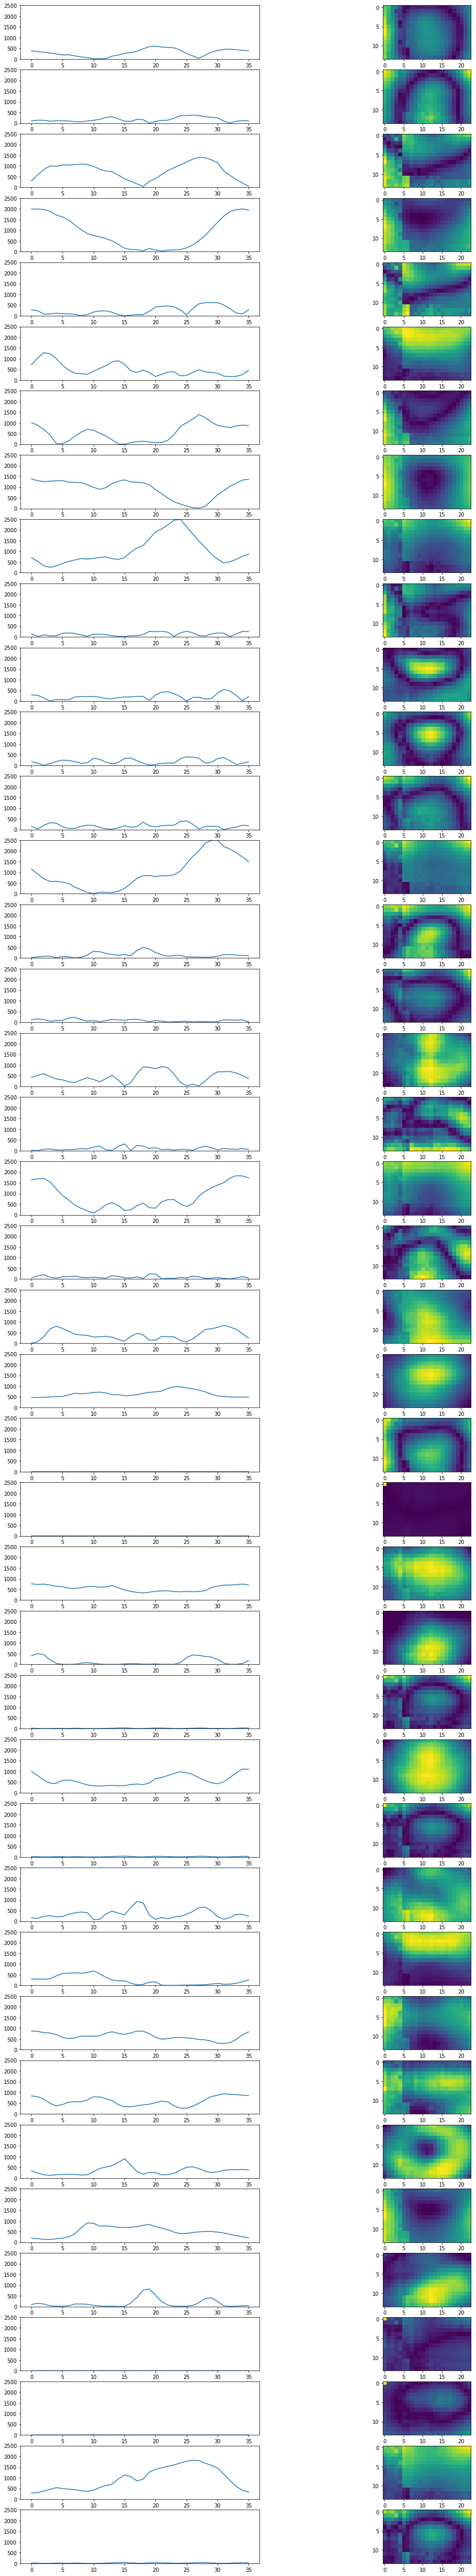

In [33]:
fig, axs = plt.subplots(40, 2, figsize=(18, 90))
for example_i in range(40):
    axs[example_i][0].plot(np.abs(head_map_4_head_cell[:, example_i]))
    axs[example_i][0].set_ylim(0, 2500)
#     min_val = min(head_map_4_head_cell[:, example_i])
#     max_val = max(head_map_4_head_cell[:, example_i])
#     axs[example_i][0].set_title('min = ' + str(min_val) + ' max = ' + str(max_val) + '\nDifferent = ' + str(max_val-min_val) + '\n...')
    axs[example_i][1].imshow(np.abs(place_map_4_head_cell[:, 0:23, example_i]))
plt.show()

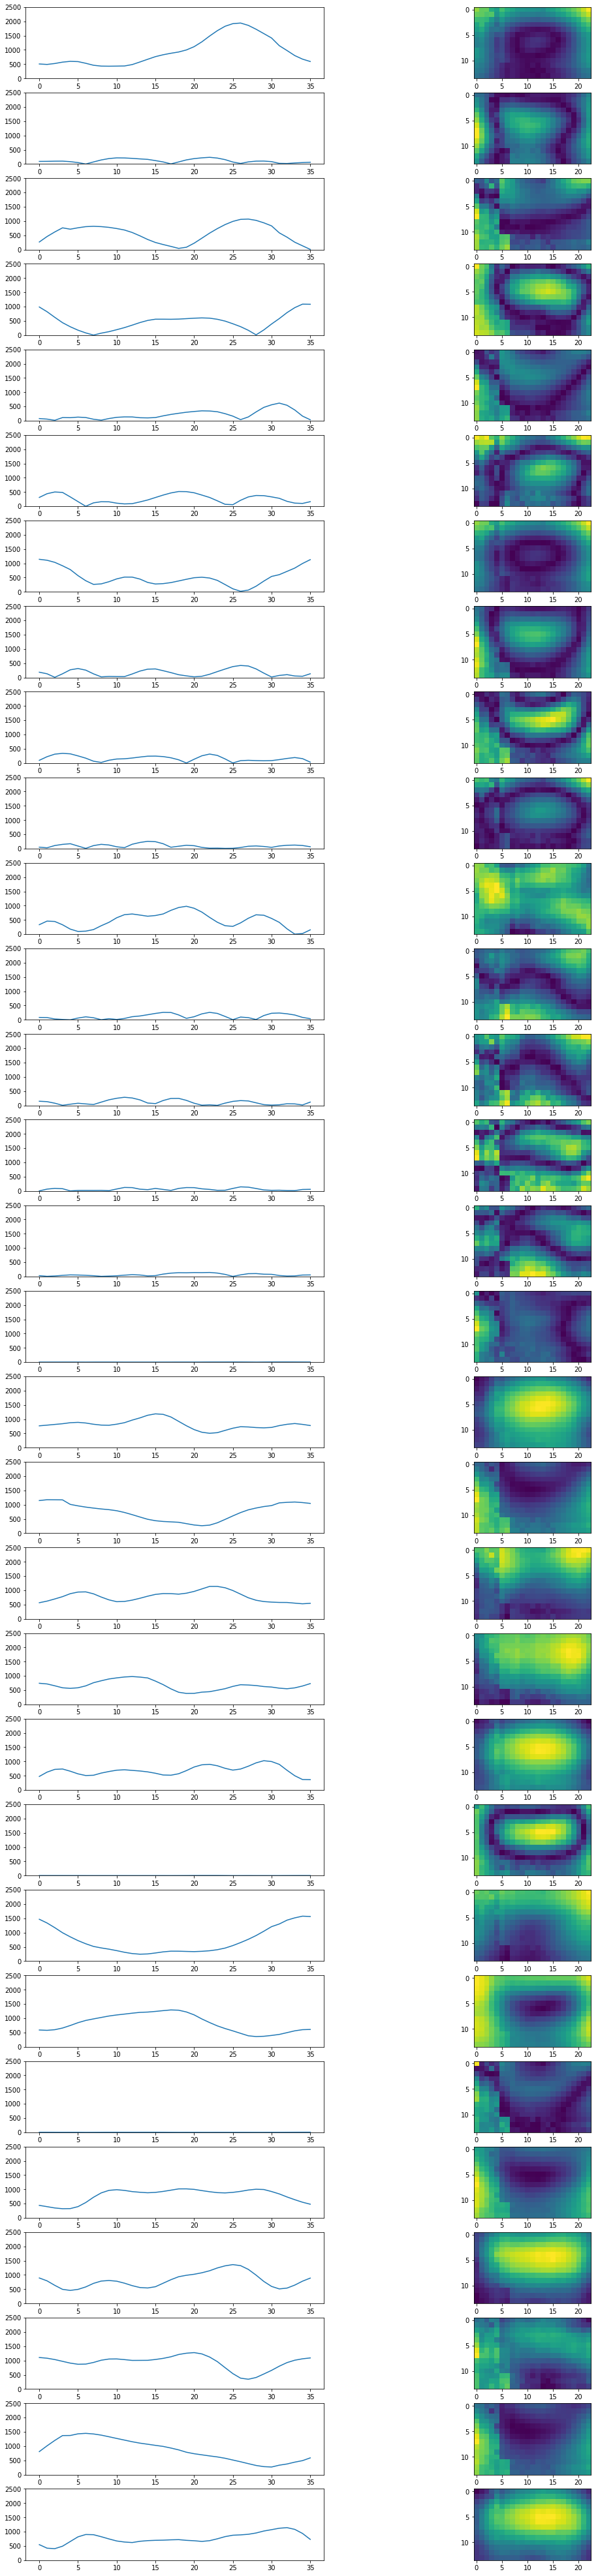

In [34]:
fig, axs = plt.subplots(30, 2, figsize=(18, 72))
for example_i in range(30):
    axs[example_i][0].plot(np.abs(head_map_4_place_cell[:, example_i]))
    axs[example_i][0].set_ylim(0, 2500)
#     min_val = min(head_map_4_head_cell[:, example_i])
#     max_val = max(head_map_4_head_cell[:, example_i])
#     axs[example_i][0].set_title('min = ' + str(min_val) + ' max = ' + str(max_val) + '\nDifferent = ' + str(max_val-min_val) + '\n...')
    axs[example_i][1].imshow(np.abs(place_map_4_place_cell[:, 0:23, example_i]))
plt.show()